# Create functions to read and run queries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    conn = sqlite3.connect("chinook.db")
    cur = conn.cursor()
    show_data = pd.read_sql(q, conn)
    return show_data

In [2]:
q = '''
        SELECT name, type FROM sqlite_master
        WHERE type IN ("table", "view")
        '''
run_query(q)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Checkout the popular genres in the US

In [3]:
popular_genre_usa = '''
WITH hot_songs_usa AS 
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA' 
    )
    
SELECT 
    g.name genre,
    count(hsu.invoice_line_id) tracks_sold,
   (count(hsu.invoice_line_id)*1.0 / (SELECT count(*) from hot_songs_usa) *100) per_sold
FROM hot_songs_usa hsu
INNER JOIN track t ON t.track_id = hsu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''

run_query(popular_genre_usa)

,genre,tracks_sold,per_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


# Visualize top genres in the US

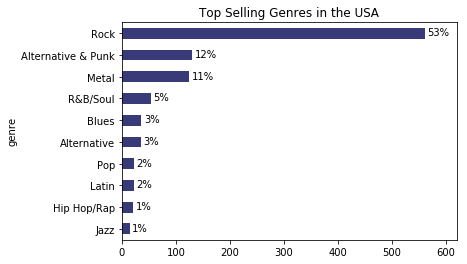

In [4]:
genres_sold_usa = run_query(popular_genre_usa)
genres_sold_usa.set_index('genre', inplace = True, drop =True)
genres_sold_usa.sort_values('tracks_sold', inplace=True)

genres_sold_usa['tracks_sold'].plot.barh(
    title = 'Top Selling Genres in the USA',
    xlim = (0, 620),
    colormap = plt.cm.tab20b
    )

for i, label in enumerate(list(genres_sold_usa.index)): 
    track_num = genres_sold_usa.loc[label, "tracks_sold"]
    label = genres_sold_usa.loc[label, "per_sold"].astype(int).astype(str) + '%'
    
    plt.annotate(str(label), (track_num+5, i-0.1))

plt.show()

# Employees' performance

In [5]:
employee_sales = '''
SELECT 
    e.first_name || " " || e.last_name employee,
    Sum(i.total) total_sales,
    e.hire_date hired_date
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
ORDER BY 2 DESC
'''

run_query(employee_sales)

,employee,total_sales,hired_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


# Visualize employees' performance

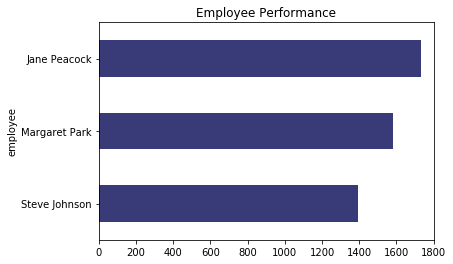

In [6]:
employee_performance = run_query(employee_sales)

employee_performance.set_index('employee', inplace=True, drop=True)
employee_performance.sort_values('total_sales', inplace=True)
employee_performance['total_sales'].plot.barh(
    title = 'Employee Performance',
    xlim =(0, 1800),
    colormap = plt.cm.tab20b
)
plt.show()

# Sales by country

In [7]:
Q = '''
WITH sales_per_country AS
    (
    SELECT 
        c.country country,
        count(distinct c.customer_id) customers,
        count(c.customer_id) orders,
        sum(i.total) total_sales
    FROM customer c 
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    ORDER BY 4 DESC
    )
    
SELECT 
    spc.*,
    spc.total_sales/spc.orders*1.0 average_sales,
    spc.total_sales/spc.customers*1.0 sales_per_customer
FROM sales_per_country spc
    '''
total_sales_country = run_query(Q)

In [8]:
total_sales_country

,country,customers,orders,total_sales,average_sales,sales_per_customer
0,USA,13,131,1040.49,7.942672,80.037692
1,Canada,8,76,535.59,7.047237,66.948750
2,Brazil,5,61,427.68,7.011148,85.536000
3,France,5,50,389.07,7.781400,77.814000
4,Germany,4,41,334.62,8.161463,83.655000
5,Czech Republic,2,30,273.24,9.108000,136.620000
6,United Kingdom,3,28,245.52,8.768571,81.840000
7,Portugal,2,29,185.13,6.383793,92.565000
8,India,2,21,183.15,8.721429,91.575000
9,Ireland,1,13,114.84,8.833846,114.840000


In [9]:
Other = total_sales_country[total_sales_country['customers'] == 1].sum()
Other = (Other.to_frame()).transpose()
Other['country'] = 'Other_countries'
Other['average_sales'] = Other['total_sales']/Other['orders']
Other['sales_per_customer'] = Other['total_sales']/Other['customers']

Other

,country,customers,orders,total_sales,average_sales,sales_per_customer
0,Other_countries,15,147,1094.94,7.44857,72.996


In [10]:
d1 = total_sales_country[total_sales_country['customers']!=1]
data_list = [d1, Other]
sales_by_country = pd.concat(data_list, sort=False)
sales_by_country

,country,customers,orders,total_sales,average_sales,sales_per_customer
0,USA,13,131,1040.49,7.94267,80.0377
1,Canada,8,76,535.59,7.04724,66.9488
2,Brazil,5,61,427.68,7.01115,85.536
3,France,5,50,389.07,7.7814,77.814
4,Germany,4,41,334.62,8.16146,83.655
5,Czech Republic,2,30,273.24,9.108,136.62
6,United Kingdom,3,28,245.52,8.76857,81.84
7,Portugal,2,29,185.13,6.38379,92.565
8,India,2,21,183.15,8.72143,91.575
0,Other_countries,15,147,1094.94,7.44857,72.996


# Visualize sales information

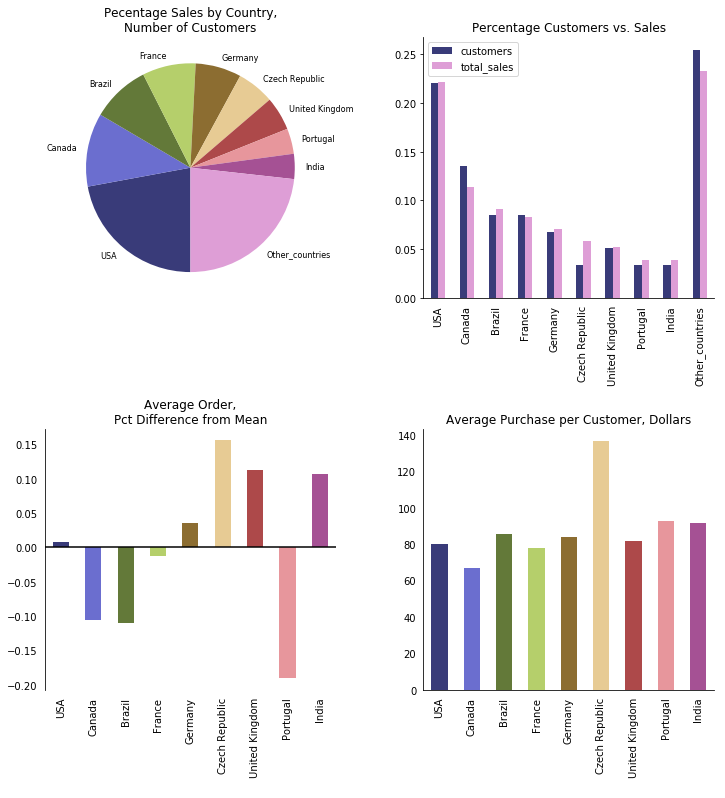

In [11]:
music_sales = sales_by_country.copy()
music_sales.set_index('country', inplace=True, drop=True)
colors = [plt.cm.tab20b(i) for i in np.linspace(0,1, music_sales.shape[0])]
# divide numbers of colors in Accent equal to the rows of the music_sales dataset 


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)


# top left - pie chart
music_sales1 = music_sales['total_sales'].copy().rename('')

music_sales1.plot.pie (
    ax = ax1,
    startangle = -90,
    counterclock = False,
    title = 'Pecentage Sales by Country,\nNumber of Customers',
    colormap = plt.cm.tab20b,
    fontsize = 8,
    wedgeprops = {'linewidth': 0}
)

# top right - bar chart
# each country's(customers,total_sales) divided by
# aggregate(customers,total_sales)
cns_cols = ['customers', 'total_sales'] 
music_sales2 = music_sales[cns_cols].copy()
music_sales2.index.name = ' '
for c in music_sales2:
    music_sales2[c] =  music_sales2[c]/music_sales2[c].sum()

music_sales2.plot.bar(
    ax=ax2,
    title = 'Percentage Customers vs. Sales',
    colormap = plt.cm.tab20b
)
ax2.tick_params(top=False, bottom=False, right=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#bottom left -bar chart
avg_sales = music_sales['average_sales'].copy()
avg_sales.index.name = ' '
avg_sales.drop('Other_countries', inplace=True)
diff_from_avg = (avg_sales - avg_sales.mean())/avg_sales.mean() 
diff_from_avg.plot.bar(
    ax=ax3,
    color = colors,
    title='Average Order,\nPct Difference from Mean'
)
ax3.tick_params(top=False, bottom=False, left=False, right=False)
ax3.axhline(0, color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


# bottom right
sales_per_cust = music_sales['sales_per_customer'].copy()
sales_per_cust.index.name = ' '
sales_per_cust.drop('Other_countries', inplace=True)
sales_per_cust.plot.bar(
    ax=ax4,
    color=colors,
    title='Average Purchase per Customer, Dollars'
)
ax4.tick_params(top=False, bottom=False, left=False, right=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
plt.show()

In [12]:
music_sales 

,customers,orders,total_sales,average_sales,sales_per_customer
country,,,,,
USA,13,131,1040.49,7.94267,80.0377
Canada,8,76,535.59,7.04724,66.9488
Brazil,5,61,427.68,7.01115,85.536
France,5,50,389.07,7.7814,77.814
Germany,4,41,334.62,8.16146,83.655
Czech Republic,2,30,273.24,9.108,136.62
United Kingdom,3,28,245.52,8.76857,81.84
Portugal,2,29,185.13,6.38379,92.565
India,2,21,183.15,8.72143,91.575
